In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## As an example let us consider a sequence of 3

In [2]:
# let the seq be of 3 token. Ex: Apple is Red
seq= np.arange(3)
seq

array([0, 1, 2])

Let each term of the sequence have a random embedding associated with it

In [3]:
seq_embeddings = {}

for token in seq:
    seq_embeddings[token] = np.random.randn(2)
print(seq_embeddings)

{0: array([-0.35109261, -1.05745995]), 1: array([0.27771255, 1.53500773]), 2: array([-2.24266332,  0.12438091])}


## 2D ROPE

theta_i = 10000^(-2(i-1)/d) where i = {1,2,..,d/2} 

In [4]:
def rotate(tensor,seq_pos):
    '''
        Rotates the tensor by seq_pos*theta
    '''
    i = 1 #the relevance of this value will become more clear in the n-d part. but basically it indicates the number of theta in a vector. for 2d vector there is only 1 theta so d = 1
    d = 2 #dimension of the embedding matrix
    theta = 10000**(-2*(i-1)/d) # since we have only 2D embedding vector hence there will be 1 theta, for n dimensional vector theta will be list of n/2 values
    
    rotation_angle = seq_pos*theta
    cos_val = np.cos(rotation_angle)
    sin_val = np.sin(rotation_angle)
    rotation_matrix = np.array([[cos_val,-sin_val],[sin_val,cos_val]])#[[cos_theta -sin_theta  ][sin_theta cos_theta]]
    rope = np.matmul(tensor,rotation_matrix)
    return rope
    
    

In [5]:
def cal_attn_score(key,query,seq_pos_key,seq_pos_query):
    rope_key = rotate(key,seq_pos_key)
    rope_query = rotate(query,seq_pos_query)
    return np.dot(rope_key,rope_query)

## the property of RoPE is to capture the relative pos between two tokens during attention:

as per the paper :

attention_score(RoPE(key,seq_pos_key),RoPE(query,seq_pos_query)) 
= dot_product(RoPE(key,(seq_pos_key-seq_pos_query),RoPE(query,0))

> hence lets check if our implementation is correct

In [6]:
#lets calculate the attention score between token 1 and token 2
attn_score = cal_attn_score(key=seq_embeddings[1],
               query=seq_embeddings[2],
               seq_pos_key=1,
               seq_pos_query=2)

In [7]:
#lets get RoPE(key,(seq_pos_key-seq_pos_query)
rotate_key_relative = rotate(seq_embeddings[1],1-2)
#lets get RoPE(query,0)
rotate_query_0 = rotate(seq_embeddings[2],0)
#get dot product 
dot_prod_val = np.dot(rotate_key_relative,rotate_query_0)

Attention score 2.6924835215605047 and dot prod val 2.6924835215605047


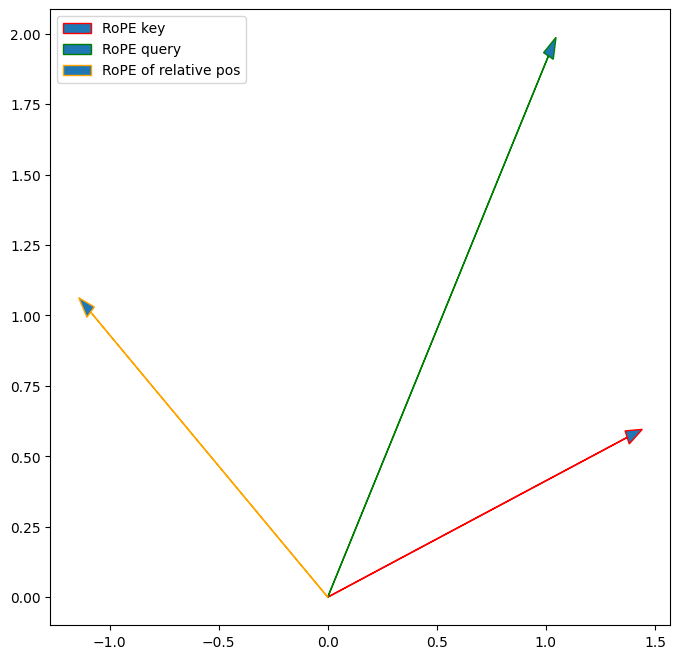

In [8]:
#lets check, since floating point calculation will not be exact, we can round to 8
assert round(attn_score,8)==round(dot_prod_val,8)
print(f"Attention score {attn_score} and dot prod val {dot_prod_val}")


#visualize the rotation

fig,ax = plt.subplots(figsize=(8,8))
rotate_key = rotate(seq_embeddings[1],1)
rotate_query = rotate(seq_embeddings[2],2)

ax.arrow(0,0,rotate_key[0],rotate_key[1],ec="red",label="RoPE key",head_width = 0.05,length_includes_head=True)
ax.arrow(0,0,rotate_query[0],rotate_query[1],ec="green",label="RoPE query",head_width = 0.05,length_includes_head=True)
ax.arrow(0,0,rotate_key_relative[0],rotate_key_relative[1],ec="orange",label="RoPE of relative pos",head_width = 0.05,length_includes_head=True)
ax.legend()


## Now that we understand how RoPE works for 2D embedding vectors , lets move onto nD vectors

> Nothing crazy here, just the nd vector is divided into n/2 parts and each of the n/2 part is treated like the 2d vector that we saw above

> hence for rope it is a requirement for the embedding vector to be multiple of 2

In [9]:
d = 16 #let each embedding vector be of dim 16

In [10]:

seq_embeddings_nd = dict()
for token in seq:
    seq_embeddings_nd[token] = np.random.randn(d)

seq_embeddings_nd

{0: array([-0.28995817, -0.46783317, -0.57677614, -0.33055751,  0.32583219,
         0.58227453, -1.52858365,  0.93483445, -0.44814248,  1.21091794,
         0.10272833,  1.5006872 , -0.55439145, -1.63818388, -1.62434592,
        -0.57641164]),
 1: array([ 1.17960805, -0.6309661 ,  1.34291297,  0.44029472, -0.46861914,
         0.09005546,  2.1253865 , -1.12219735,  0.51959046, -0.69338408,
         0.27455583, -0.21022263,  0.42839665, -0.28840528, -0.66262147,
         1.18848728]),
 2: array([ 0.98842776,  0.30124654,  0.27680599, -0.17167663,  0.4245087 ,
         0.46592125, -1.13874902, -1.06454504, -0.18840422, -0.53678396,
         1.90661765, -0.41921273,  0.65951122, -0.22987691, -0.27090335,
         0.04484568])}

In [11]:
seq_embeddings_nd[0].shape[-1]

16

> if you compare rotate_nd with the above rotate, you will observe both are exactly the same except rotate_nd has for loops now

In [12]:
def rotate_nd(tensor,seq_pos):
    dim_of_tensor = tensor.shape[-1]
    
    #dividing the tensor into groups of 2
    tensor_divided = np.array_split(tensor,dim_of_tensor//2)
    
    #theta will be a list of size dim_of_tensor/2
    theta= []
    for i in range(dim_of_tensor//2):
        rotation_angle = seq_pos * 10000**(-2*(i-1)/d)  
        theta.append(rotation_angle)
    
    rotated_tensor = []
    for tensor,angle in zip(tensor_divided,theta):
        cos_val = np.cos(angle)
        sin_val = np.sin(angle)
        rotation_matrix = np.array([[cos_val,-sin_val],[sin_val,cos_val]])
        rotated_tensor.append(np.matmul(tensor,rotation_matrix))
    
    #after rotation of each group of size 2, lets make the tensor 1 again
    rotated_tensor = np.array(rotated_tensor)
    rotated_tensor = rotated_tensor.reshape(dim_of_tensor)
    
    return rotated_tensor
    

> there you Go ! you have the rope of nd vectors

In [13]:
rotate_nd(seq_embeddings_nd[1],1)

array([-1.16630509,  0.65522958,  1.0960742 , -0.89213005, -0.41737702,
        0.23132295,  2.00273563, -1.32877563,  0.49740761, -0.70946557,
        0.27243991, -0.21295763,  0.42748249, -0.28975854, -0.66143265,
        1.18914931])

In [14]:
def cal_attn_score_nd(key,query,seq_pos_key,seq_pos_query):
    rope_key = rotate_nd(key,seq_pos_key)
    rope_query = rotate_nd(query,seq_pos_query)
    attn_score = np.dot(rope_key,rope_query)
    return attn_score

In [15]:
#let token 1 be the key and token 2 be the query
attn_score_nd = cal_attn_score_nd(key = seq_embeddings[1],query = seq_embeddings[2],seq_pos_key=1,seq_pos_query=2)

#### Lets verify this too!

In [16]:
#lets get RoPE(key,(seq_pos_key-seq_pos_query)
rotate_key_relative = rotate_nd(seq_embeddings[1],1-2)
#lets get RoPE(query,0)
rotate_query_0 = rotate_nd(seq_embeddings[2],0)
#get dot product 
dot_prod_val = np.dot(rotate_key_relative,rotate_query_0)

In [17]:
#lets check, since floating point calculation will not be exact, we can round to 8
assert round(attn_score_nd,8)==round(dot_prod_val,8)
print(f"Attention score {attn_score_nd} and dot prod val {dot_prod_val}")

Attention score 0.35988005661782324 and dot prod val 0.35988005661782324


>> Wohoo! now you know all there is to know about ROPE
